In [1]:
import os
import sys
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm
os.environ['CLMM_MODELING_BACKEND'] = 'nc'

__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

import clmm
import numpy as np
from numpy import random
from clmm import Cosmology
from clmm.support import mock_data as mock
from chainconsumer import ChainConsumer
import matplotlib.pyplot as plt

plt.rcParams['text.latex.preamble'] = [r'\usepackage{pxfonts, mathpazo}']
plt.rc('text', usetex=True)

In [2]:
np.random.seed(1)
# Define cosmological parameters
cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

cluster_m     = 1.e15 # Cluster mass
cluster_z     = 0.4   # Cluster redshift
concentration = 4     # Concentrion parameter NFW profile
ngals         = 10000 # Number of galaxies
Delta         = 200   # Overdensity parameter definition NFW profile
cluster_ra    = 0.0   # Cluster right ascension
cluster_dec   = 0.0   # Cluster declination
sigma_g       = 5e-2  # True ellipticity standard variation
sigma_z       = 5e-2
ndata         = 1000
scale         = 1e-2


In [3]:
# Create Model Set
moo = clmm.Modeling (massdef='mean', delta_mdef=200, halo_profile_model='nfw')
moo.set_cosmo(cosmo)
mset = moo.get_mset ()

MDelta_pi = mset.param_get_by_full_name ("NcHaloDensityProfile:log10MDelta")
cDelta_pi = mset.param_get_by_full_name ("NcHaloDensityProfile:cDelta")

mset.param_set_ftype (MDelta_pi.mid, MDelta_pi.pid, Ncm.ParamType.FREE)
mset.param_set_ftype (cDelta_pi.mid, cDelta_pi.pid, Ncm.ParamType.FREE)
mset.prepare_fparam_map ()

# Create data
data = mock.generate_galaxy_catalog (cluster_m, cluster_z, concentration, cosmo, "chang13", zsrc_min = cluster_z + 0.1, shapenoise=sigma_g, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec, photoz_sigma_unscaled=sigma_z)
gc = clmm.GalaxyCluster("CL_noisy_z", cluster_ra, cluster_dec, cluster_z, data)
gc.compute_tangential_and_cross_components(geometry="flat")
r = clmm.convert_units (gc.galcat['theta'], "radians", "Mpc", redshift = cluster_z, cosmo = cosmo)

obs = Ncm.Matrix.new (len (gc.galcat['theta']), 3)

for i in range (len (gc.galcat['theta'])):
    obs.set (i, 0, r[i])
    obs.set (i, 1, gc.galcat['z'][i])
    obs.set (i, 2, gc.galcat['et'][i])

In [4]:
gsdp  = Nc.GalaxySDPositionFlat ()
gsdzp = Nc.GalaxySDZProxyGauss ()
gsds  = Nc.GalaxySDShapeGauss ()

# gsdp.set_z_lim (Ncm.Vector.new_array ([1e-6, 10]))
# gsdp.set_r_lim (Ncm.Vector.new_array ([1e-6, 10]))
# gsdzp.set_z_lim (Ncm.Vector.new_array ([1e-6, 10]))

gsdp.set_z_lim (Ncm.Vector.new_array ([0.4, 4.5]))
gsdp.set_r_lim (Ncm.Vector.new_array ([0.3, 4.5]))
gsdzp.set_z_lim (Ncm.Vector.new_array ([0.4, 4.5]))

gsdzp.set_sigma (sigma_z)
gsds.set_sigma (sigma_g)

gwll = Nc.GalaxyWLLikelihood (s_dist=gsds, zp_dist=gsdzp, rz_dist=gsdp)
gwll.set_obs (obs)
gwll.set_ndata (ndata)
gwll.set_cut (cluster_z + 0.1, 2.4, 0.75, 3.0)
gwll.set_scale_cut (scale)

ga = Ncm.ObjArray.new ()
ga.add (gwll)

dcwll = Nc.DataClusterWLL (galaxy_array=ga, z_cluster=cluster_z)
dcwll.set_init (True)

dset = Ncm.Dataset.new ()
dset.append_data (dcwll)
lh = Ncm.Likelihood.new (dset)
fit = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD)

In [5]:
fit.run (Ncm.FitRunMsgs.SIMPLE)
fit.obs_fisher ()
fit.log_info ()
fit.log_covar ()

#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (forward)
#...............
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:39:52.3877760
#  iteration            [000063]
#  function evaluations [000065]
#  gradient evaluations [000000]
#  degrees of freedom   [009998]
#  m2lnL     =     -2711.0036545728 (    -2001.9256 )
#  Fit parameters:
#     4.0296875            14.386967495664     



(process:11811): NUMCOSMO-WARNING **: 15:26:53.499: _ncm_fit_nlopt_run: algorithm minimum differs from evaluated m2lnL      -2001.92557246601 !=       -2711.0036545728 (prec = 1.000000e-08)



In [ ]:
Ncm.func_eval_set_max_threads (12)
Ncm.func_eval_log_pool_stats ()

init_sampler = Ncm.MSetTransKernGauss.new (0)
init_sampler.set_mset (mset)
init_sampler.set_prior_from_mset ()
init_sampler.set_cov_from_rescale (1.0e-1)

nwalkers = 200
stretch = Ncm.FitESMCMCWalkerAPES.new (nwalkers, mset.fparams_len ())
esmcmc  = Ncm.FitESMCMC.new (fit, nwalkers, init_sampler, stretch, Ncm.FitRunMsgs.SIMPLE)
# esmcmc.set_auto_trim_div (100)
# esmcmc.set_max_runs_time (2.0 * 60.0)
esmcmc.set_nthreads(12)
esmcmc.start_run ()
esmcmc.run (10000/nwalkers)
esmcmc.end_run ()

mcat = esmcmc.peek_catalog ()


# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  2
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      12
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensemble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 0200.
#   Number of threads: 0012.
#   Using MPI:         no - use MPI enabled but no slaves available.
# NcmFitESMCMC: No RNG was defined, using algorithm: `mt19937' and seed: 2404437926.


sys:1: Warning: g_value_set_int: assertion 'G_VALUE_HOLDS_INT (value)' failed
/tmp/ipykernel_11739/2247139094.py:15: Warning: g_value_set_int: assertion 'G_VALUE_HOLDS_INT (value)' failed
  esmcmc.start_run ()


# NcmMSetCatalog: Current mean:   3.3144e+05   4.001        14.307     
# NcmMSetCatalog: Current msd:    14094        0.00072122   0.0034811  
# NcmMSetCatalog: Current sd:     1.9932e+05   0.0102       0.04923    
# NcmMSetCatalog: Current var:    3.973e+10    0.00010403   0.0024235  
# NcmMSetCatalog: Current tau:    1            1            1          
# NcmMSetCatalog: Current skfac: -nan         -nan         -nan        
# NcmMSetCatalog: Maximal Shrink factor = 1e+10                 
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Computing the constant break point for parameter `0', sample size `1':
# NcmMSetCatalog: Constant break point at `0':
# NcmFitESMCMC:last ensemble variance of -2ln(L):       39891056038.6683 (2n = 4), min(-2ln(L)) =       29666.2957878783.
# Task:NcmFitESMCMC, completed: 200 of 200, elapsed time: 00:00:02.9676
# Task:NcmFitESMCMC, mean time: 00:00:00.0147 +/- 00:00:00.0147
# Task:NcmFitESMCMC, time

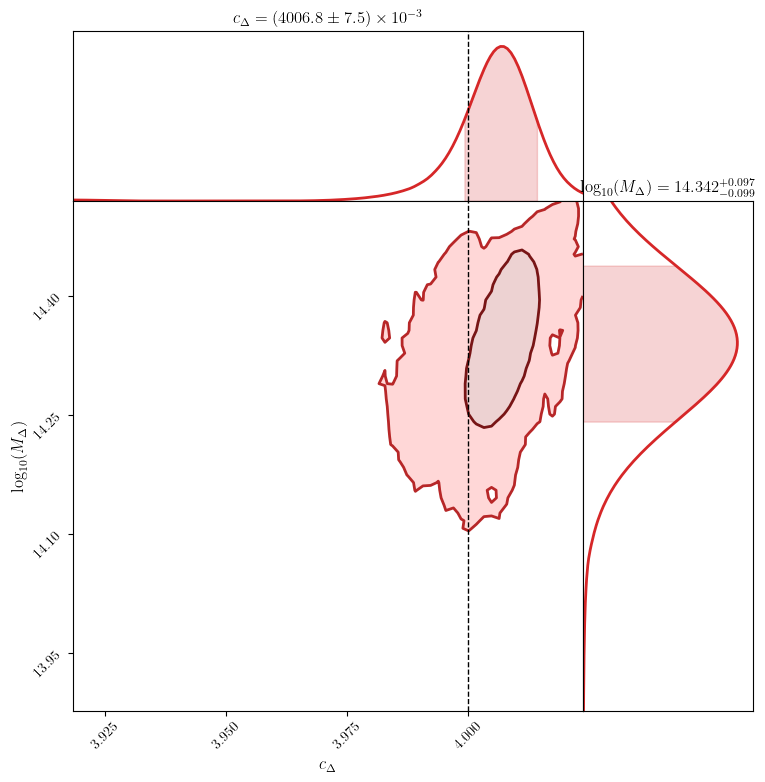

In [ ]:
rows = np.array([mcat.peek_row(i).dup_array() for i in range(nwalkers * 40, mcat.len())])
params = ["$" + mcat.col_symb(i) + "$" for i in range (mcat.ncols())]

partial = ChainConsumer ()
partial.add_chain(rows[:,1:], parameters=params[1:], name=f"$\sigma_{{\epsilon^s}} = {sigma_g}$")
partial.configure(spacing=0.0, usetex=True, colors='#D62728', shade=True, shade_alpha=0.2, bar_shade=True, smooth=True, kde=True, legend_color_text=False, linewidths=2)

CC_fig = partial.plotter.plot(figsize=(8, 8), truth=[4, 15])

fig = plt.figure(num=CC_fig, figsize=(8,8), dpi=300, facecolor="white")